# Taxon definition and lineage

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import toytree
import toyplot
import scipy.stats as sc

import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from adascape.base import IR12SpeciationModel, DD03SpeciationModel
from adascape.fastscape_ext import FastscapeElevationTrait

## Functions to compute and visualize speciation model

In [2]:
def run_model(trait_comp=False, num_gen=100, pop_size = 10, dt=1,
             sigma_env_trait=0.3, mut_prob=1.0, sigma_mut=0.05, sigma_mov=5,
             random_seed=1234, taxon_threshold=0.01,
             taxon_def='traits',always_direct_parent=True):
    length = (250, 250)
    spacing = (1, 1)
    X, Y = np.meshgrid(*[np.arange(0, l + s, s) for l, s in zip(length, spacing)])
    r = np.random.RandomState(0)
    environment = X + r.rand(*Y.shape)
    trait_01_elev = FastscapeElevationTrait(topo_elevation=environment,
                                        init_trait_min=0.5,
                                        init_trait_max=0.5,
                                        lin_slope=0.95, 
                                        norm_min=environment.min(), 
                                        norm_max=environment.max(), 
                                        random_seed=1234)
    trait_01_elev.initialize()
    init_trait_funcs =  {
    'trait_1': trait_01_elev.init_trait_func,
    }
    opt_trait_funcs = {
    'trait_1': trait_01_elev.opt_trait_func
    }
    
    if trait_comp:
        model = DD03SpeciationModel(X, Y, init_trait_funcs, opt_trait_funcs, pop_size,
                                    car_cap_max=250, sigma_env_trait=sigma_env_trait, mut_prob=mut_prob, 
                                    sigma_mut=sigma_mut, sigma_mov=sigma_mov, sigma_comp_trait=sigma_env_trait, 
                                    sigma_comp_dist=sigma_env_trait, random_seed=random_seed, 
                                    taxon_threshold=taxon_threshold, 
                                    taxon_def=taxon_def, always_direct_parent=always_direct_parent)
    else:
        model = IR12SpeciationModel(X, Y, init_trait_funcs, opt_trait_funcs, pop_size, 
                                    nb_radius=50, car_cap=25, sigma_env_trait=sigma_env_trait, mut_prob=mut_prob, 
                                    sigma_mut=sigma_mut, sigma_mov=sigma_mov, random_seed=random_seed, 
                                    taxon_threshold=taxon_threshold, 
                                    taxon_def=taxon_def, always_direct_parent=always_direct_parent)

    model.initialize()
    dfs = []
    for step in range(num_gen):
        model.evaluate_fitness(dt)
        dfs.append(model.to_dataframe())
        model.update_individuals(dt)
    return pd.concat(dfs).reset_index(drop=True), environment, X

In [3]:
def plot_sol(dtf, elevation, X):
    num_gen = dtf.step.unique().size
    fig1, axs1 = plt.subplots(2, 2, sharex="col", figsize=(12, 6))
    axs1[0,0].plot(dtf.groupby('step').size())
    h,xedge,yedge,_=axs1[1,0].hist2d(x=dtf['step'], y=dtf['trait_0'],
                                     range=((0, num_gen), (0, 1)),
                                     bins=(num_gen, 100), cmap='bone_r')
    axs1[0, 1].pcolormesh(elevation)
    axs1[0, 1].scatter(dtf['x'].loc[dtf['step']==max(dtf['step'])],
                       dtf['y'].loc[dtf['step']==max(dtf['step'])],
                       c=dtf['trait_0'].loc[dtf['step']==max(dtf['step'])],
                       edgecolor='w',vmin=0, vmax=1)
    h,xedge,yedge,_=axs1[1,1].hist2d(x=dtf['x'].loc[dtf['step']==max(dtf['step'])],
                                     y=dtf['trait_0'].loc[dtf['step']==max(dtf['step'])],
                                     range=((0, X.max()), (0, 1)),
                                     bins=(25, 250), cmap='bone_r')
    axs1[0, 1].yaxis.set_label_position("right")
    axs1[0, 1].yaxis.tick_right()
    axs1[1, 1].yaxis.set_label_position("right")
    axs1[1, 1].yaxis.tick_right()
    axs1[0, 1].set_ylabel('Y', weight='bold')
    axs1[0, 0].set_ylabel('Abundance (No. ind)', weight='bold')
    axs1[1, 1].set_ylabel('Trait', weight='bold')
    axs1[1, 0].set_ylabel('Trait', weight='bold')
    axs1[1, 1].set_xlabel('X', weight='bold')
    axs1[1, 0].set_xlabel('Time (generations)', weight='bold')

In [4]:
def toytree_plot(tree, ind_dtf):
    """
    Plot of phylogenetic tree using library toytree and following the cookbook example 
    https://toytree.readthedocs.io/en/latest/
    
    Parameters
    ----------
    tree : class 'dendropy.tree'
        Phylogenetic tree as class dendropy.tree
    ind_dtf : class 'pandas.DataFrame'
        Speciation model output with data for all individuals
        
    """
    ttree = toytree.tree(tree.as_string(schema='newick'))
    # generate a distribution between 0 and 1 for each tip in the tree
    points = np.linspace(0, 1, 50)
    dists = {}
    for tip in ttree.get_tip_labels():
        trait_values = ind_dtf[ind_dtf.taxon_id==int(tip)].trait_0.values
        if trait_values.size > 1:
            kernel = sc.gaussian_kde(trait_values)                                 
            dists[tip] = kernel(points)
        else:
            dists[tip] = None
    # set up canvas for two panel plot
    canvas = toyplot.Canvas(width=300, height=400)

    # add tree to canvas
    ax0 = canvas.cartesian(bounds=(50, 180, 50, 350), ymin=0, ymax=ttree.ntips, padding=15)
    ttree.draw(axes=ax0, tip_labels=False)
    ax0.show = False

    # add histograms to canvas
    ax1 = canvas.cartesian(bounds=(200, 275, 50, 350), ymin=0, ymax=ttree.ntips, padding=15)

    # iterate from top to bottom (ntips to 0)
    for tip in range(ttree.ntips)[::-1]:

        # select a color for hist
        color = toytree.colors[int((tip) / 100)]

        # get tip name and get hist from dict
        tipname = ttree.get_tip_labels()[tip]
        probs = dists[tipname]
        
        if probs is not None:
            
            # fill histogram with slightly overlapping histograms
            ax1.fill(
                points, probs / probs.max() * 1.25,
                baseline=[tip] * len(points),
                style={"fill": color, "stroke": "white", "stroke-width": 0.5},
                title=tipname,
            )
            # add horizontal line at base
            ax1.hlines(tip, opacity=0.5, color="grey", style={"stroke-width": 0.5})

    # hide y axis, show x
    ax1.y.show = False
    ax1.x.label.text = "Trait value"
    ax1.x.ticks.show = True

## Phylogeny for the speciation model without trait-mediated competition

In [5]:
ind_dtf1, elevation1, X1 = run_model(trait_comp=False)

/Users/acevedo/opt/anaconda3/envs/adascape-dev/lib/python3.10/site-packages/scipy/cluster/vq.py:603: UserWarning: One of the clusters is empty. Re-run kmeans with a different initialization.
  warnings.warn("One of the clusters is empty. "


In [6]:
ind_dtf1

,step,time,dt,x,y,taxon_id,ancestor_id,n_offspring,fitness,trait_0
0,0,0.0,0.0,244.174942,110.251531,1.0,0.0,8,0.321987,0.500000
1,0,0.0,0.0,95.048934,152.467702,1.0,0.0,8,0.932487,0.500000
2,0,0.0,0.0,230.811558,215.905324,1.0,0.0,10,0.405734,0.500000
3,0,0.0,0.0,65.423106,215.939418,1.0,0.0,5,0.751070,0.500000
4,0,0.0,0.0,79.774265,168.720328,1.0,0.0,5,0.853670,0.500000
...,...,...,...,...,...,...,...,...,...,...
21873,99,99.0,0.0,1.832701,165.680372,3311.0,3261.0,1,0.888182,0.181212
21874,99,99.0,0.0,9.511911,184.793336,3311.0,3261.0,1,0.999809,0.069618
21875,99,99.0,0.0,6.764354,158.070961,3311.0,3261.0,1,0.999913,0.050450
21876,99,99.0,0.0,11.959988,147.630750,3311.0,3261.0,1,0.990940,0.111679


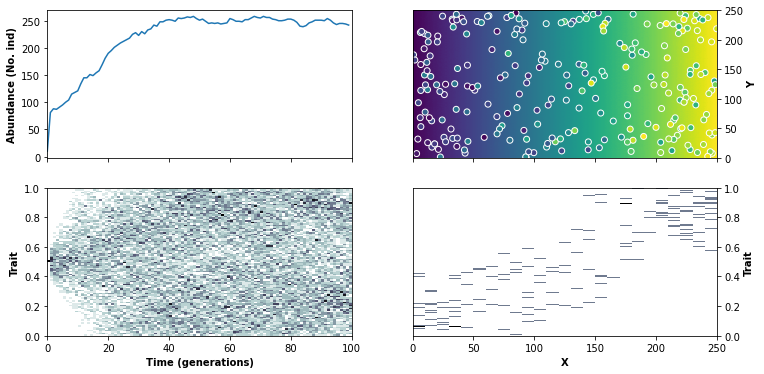

In [7]:
plot_sol(ind_dtf1, elevation1, X1)

In [8]:
taxon_lineage1 = ind_dtf1.ptree.extract_taxon_summary()
taxon_lineage1

,time,taxon_id,ancestor_id,trait_0,abundance,node_type
0,0.0,1,0,0.500000,10,root
1,1.0,2,1,0.415191,6,node
2,1.0,3,1,0.503606,75,node
3,2.0,4,2,0.432415,6,node
4,2.0,5,3,0.501486,82,node
...,...,...,...,...,...,...
3343,99.0,3344,3294,0.674965,4,leaf
3344,99.0,3345,3295,0.551351,9,leaf
3345,99.0,3346,3296,0.734405,5,leaf
3346,99.0,3347,3297,0.845146,5,leaf


In [9]:
tree1 = ind_dtf1.ptree.to_dendropy_tree()

In [10]:
tree1.print_plot()

                                                     /++++++++++++++++++++ 3299
                      /+++++++++++++++++++++++++++++++                         
                      |                              \++++++++++++++++++++ 3300
        +++++++++++++++                                                        
        |             |                                            /++++++ 3301
        |             |              /++++++++++++++++++++++++++++++           
        |             \+++++++++++++++                             \++++++ 3302
+++++++++                            |                                         
|       |                            \++++++++++++++++++++++++++++++++++++ 3303
|       |                                                                      
|       |+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ 3304
|       |                                                                      
|       +                          /++++

In [11]:
toytree_plot(tree1, ind_dtf1)

<svg class="toyplot-canvas-Canvas" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns="http://www.w3.org/2000/svg" width="300.0px" height="400.0px" viewBox="0 0 300.0 400.0" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" id="t3c9510e8860b40d78025b8337e3d321d"> <path d="M 161.5 35

## Tree summary statistics 

Phylogenetic diversity (PD)

In [12]:
sum(tree1.calc_node_root_distances())

5043.0

In [13]:
pdm1=tree1.phylogenetic_distance_matrix()

Mean pairwise distance (MPD)

In [14]:
pdm1.mean_pairwise_distance()

188.1270588235294

Mean neighbor taxon distance (MNTD)

In [15]:
pdm1.mean_nearest_taxon_distance()

101.68627450980392

Lineages through time (LTT)

Text(0, 0.5, 'Number of Lineages')

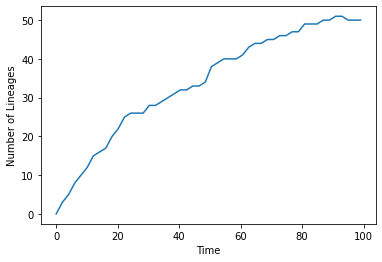

In [16]:
time_steps1 = np.linspace(0, tree1.max_distance_from_root(), 50)
ltt1=[tree1.num_lineages_at(t) for t in time_steps1]
plt.plot(time_steps1, ltt1)
plt.xlabel('Time')
plt.ylabel('Number of Lineages')

## Phylogeny for the speciation model with trait-mediated competition

In [17]:
ind_dtf2, elevation2, X2 = run_model(trait_comp=True)

/Users/acevedo/opt/anaconda3/envs/adascape-dev/lib/python3.10/site-packages/scipy/cluster/vq.py:603: UserWarning: One of the clusters is empty. Re-run kmeans with a different initialization.
  warnings.warn("One of the clusters is empty. "


In [18]:
ind_dtf2

,step,time,dt,x,y,taxon_id,ancestor_id,n_offspring,events_i,death_i,trait_0
0,0,0.0,0.0,244.174942,110.251531,1.0,0.0,2,B,0.069492,0.500000
1,0,0.0,0.0,95.048934,152.467702,1.0,0.0,1,M,0.063454,0.500000
2,0,0.0,0.0,230.811558,215.905324,1.0,0.0,1,M,0.059319,0.500000
3,0,0.0,0.0,65.423106,215.939418,1.0,0.0,1,M,0.068145,0.500000
4,0,0.0,0.0,79.774265,168.720328,1.0,0.0,2,B,0.067284,0.500000
...,...,...,...,...,...,...,...,...,...,...,...
18777,99,99.0,1.0,81.812157,158.998922,2360.0,2323.0,1,M,1.475759,0.331628
18778,99,99.0,1.0,10.952879,53.768061,2360.0,2323.0,1,M,1.496603,0.212275
18779,99,99.0,1.0,236.522691,162.187029,2360.0,2323.0,2,B,1.382710,0.841135
18780,99,99.0,1.0,109.518631,73.881668,2355.0,2318.0,2,B,1.611168,0.567459


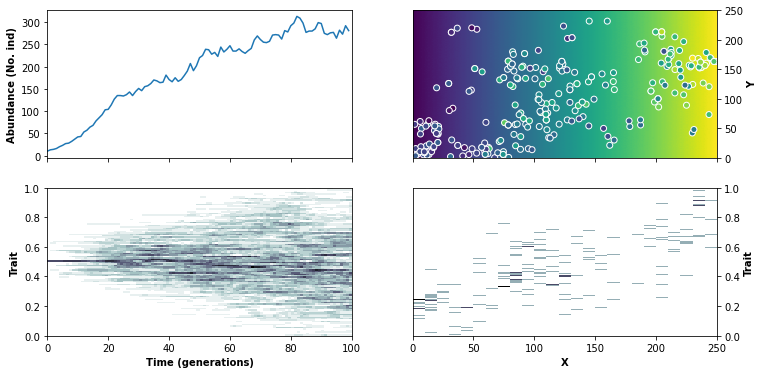

In [19]:
plot_sol(ind_dtf2, elevation2, X2)

In [20]:
taxon_lineage2 = ind_dtf2.ptree.extract_taxon_summary()
taxon_lineage2

,time,taxon_id,ancestor_id,trait_0,abundance,node_type
0,0.0,1,0,0.500000,10,root
1,1.0,2,1,0.510839,13,node
2,2.0,3,2,0.519735,14,node
3,3.0,4,3,0.510964,16,node
4,4.0,5,4,0.497380,20,node
...,...,...,...,...,...,...
2386,99.0,2387,2350,0.674690,5,leaf
2387,99.0,2388,2351,0.452625,7,leaf
2388,99.0,2389,2352,0.402859,3,leaf
2389,99.0,2390,2353,0.538031,5,leaf


In [21]:
tree2 = ind_dtf2.ptree.to_dendropy_tree()

In [22]:
tree2.print_plot()

                                                  /-------++++++++++++++++ 1986
              +++++++++++++++++++++++++++++++++++++                            
              |                                   ++++++++++++++++++++++++ 2355
              |                                                                
              |                                            /++++++++++++++ 2356
           ++++                            /++++++++++++++++                   
           |  |                            |               \++++++++++++++ 2357
           |  |                 /+++++++++++                                   
           |  |                 |          |   /------------------++++++++ 1478
           |  |                 |          \++++                               
           |  +++++++++++++++++++              | /--++++++++++++++++++++++ 2248
           |                    |              \++                             
           |                    |       

In [23]:
toytree_plot(tree2, ind_dtf2)

<svg class="toyplot-canvas-Canvas" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns="http://www.w3.org/2000/svg" width="300.0px" height="400.0px" viewBox="0 0 300.0 400.0" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" id="t2008c2eadd7d48c1ba985fe188384a25"> <polygon points="200.0,59.375 201.53061224489795,59.375 203.0612244897959,59.375 204.59183673469389,59.375 206.12244897959187,59.375 207.6530612244898,59.375 209.18367346938774,59.375 210.71428571428572,59.375 212.24489795918367,59.375 213.77551020408163,59.375 215.30612244897958,59.375 216.83673469387753,59.375 218.36734693877548,59.375 219.8979591836735,59.375 221.42857142857144,59.375 222.9591836734694,59.375 224.48979591836735,59.375 226.0204081632653,59.375 227.55102040816325,59.375 229.0816326530612,59.375 230.61224489795916,59.375 232.1428571428571,59.375 233.6734693877551,59.375 235.20408163265304,59.375 236.73469387755102,59.375 238.26530612244898,59.375 239.79591836734693,59.375 241.3265306122449,59.375 242.85714285714286,59.375 244.3877551020408,59.375 245.91836734693877,59.375 247.44897959183675,59.375 248.9795918367347,59.375 250.51020408163265,59.375 252.0408163265306,59.375 253.57142857142858,59.375 255.10204081632654,59.375 256.6326530612245,59.375 258.16326530612247,59.375 259.6938775510204,59.375 261.2244897959184,59.375 262.7551020408163,59.375 264.2857142857143,59.375 265.81632653061223,59.375 267.3469387755102,59.375 268.8775510204082,59.375 270.4081632653061,59.375 271.9387755102041,59.375 273.469387755102,59.375 275.0,59.375 275.0,59.149053061374445 273.469387755102,59.07958582706276 271.9387755102041,58.99362945848503 270.4081632653061,58.88884729573721 268.8775510204082,58.763029496791994 267.3469387755102,58.61424058116697 265.81632653061223,58.44098195872953 264.2857142857143,58.242358709856724 262.7551020408163,58.018236950045285 261.2244897959184,57.7693761420231 259.6938775510204,57.49752020665937 258.16326530612247,57.2054326239135 256.6326530612245,56.89686411025436 255.10204081632654,56.57644684805797 253.57142857142858,56.24951625403473 252.0408163265306,55.9218692258774 250.51020408163265,55.59947576008294 248.9795918367347,55.28816770060191 247.44897959183675,54.99333307037252 245.91836734693877,54.71964604463213 244.3877551020408,54.470860580500336 242.85714285714286,54.24968993504405 241.3265306122449,54.057785244656365 239.79591836734693,53.895814993876925 238.26530612244898,53.763634986921716 236.73469387755102,53.6605270003326 235.20408163265304,53.58547528253816 233.6734693877551,53.537444851182116 232.1428571428571,53.515625 230.61224489795916,53.51960578446053 229.0816326530612,53.54946401364218 227.55102040816325,53.605747279585685 226.0204081632653,53.68935815565889 224.48979591836735,53.80135399853837 222.9591836734694,53.94268894616609 221.42857142857144,54.113932196691806 219.8979591836735,54.314999516615494 218.36734693877548,54.54493288527012 216.83673469387753,54.80175667282784 215.30612244897958,55.08242882321986 213.77551020408163,55.38289365647644 212.24489795918367,55.698230789456076 210.71428571428572,56.022883901324086 209.18367346938774,56.35094494146201 207.6530612244898,56.67646472763898 206.12244897959187,56.99376000033654 204.59183673469389,57.297689639505315 203.0612244897959,57.583878223684025 201.53061224489795,57.848872433697444 200.0,58.090223868340345" style="fill:rgb(40%,76.1%,64.7%);fill-opacity:1.0;opacity:1.0;stroke:rgb(100%,100%,100%);stroke-opacity:1.0;stroke-width:0.5"> 2355 <polygon points="200.0,64.0625 201.53061224489795,64.0625 203.0612244897959,64.0625 204.59183673469389,64.0625 206.12244897959187,64.0625 207.6530612244898,64.0625 209.18367346938774,64.0625 210.71428571428572,64.0625 212.24489795918367,64.0625 

## Tree summary statistics 

Phylogenetic diversity (PD)

In [24]:
sum(tree2.calc_node_root_distances())

5550.0

In [25]:
pdm2=tree2.phylogenetic_distance_matrix()

Mean pairwise distance (MPD)

In [26]:
pdm2.mean_pairwise_distance()

149.41369047619048

Mean neighbor taxon distance (MNTD)

In [27]:
pdm2.mean_nearest_taxon_distance()

44.828125

Lineages through time (LTT)

Text(0, 0.5, 'Number of Lineages')

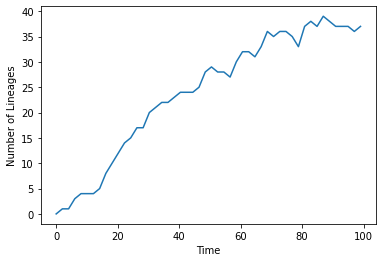

In [28]:
time_steps2 = np.linspace(0, tree2.max_distance_from_root(), 50)
ltt2 = [tree2.num_lineages_at(t) for t in time_steps2]
plt.plot(time_steps2, ltt2)
plt.xlabel('Time')
plt.ylabel('Number of Lineages')